In [1]:
import sys

package_path: str = "../.."
if package_path not in sys.path:
    sys.path.append(package_path)

%reload_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import center_of_mass
from roi_rectangle import RoiRectangle

from src.analyzer.converter import load_npz
from src.filesystem import get_run_scan_dir
from src.config import load_config, ExpConfig


config: ExpConfig = load_config(reload=True)
config.path

ExpPaths(log_dir=WindowsPath('logs'), load_dir=WindowsPath('Y:/240608_FXS/raw_data/h5/type=raw'), analysis_dir=WindowsPath('Y:/240608_FXS/analysis_data'), mat_dir=WindowsPath('Y:/240608_FXS/analysis_data/mat_files'), processed_dir=WindowsPath('Y:/240608_FXS/analysis_data/processed_data'), output_dir=WindowsPath('Y:/240608_FXS/analysis_data/output_data'))

In [5]:
run_n: int = 144
npz_file: Path = get_run_scan_dir(
    config.path.processed_dir, run_n, 1, sub_path=f"run={run_n:0>4}_scan=0001.npz"
)

_data: dict[str : npt.NDArray] = load_npz(npz_file)
delays: npt.NDArray = _data["delay"]
images: npt.NDArray = _data["pon"]

print(f'Load "{npz_file}"')
print(f"{delays.shape = }")
print(f"{images.shape = }")

Load "Y:\240608_FXS\analysis_data\processed_data\run=144\scan=001\run=0144_scan=0001.npz"
delays.shape = (61,)
images.shape = (61, 514, 1030)


In [6]:
images = np.maximum(0, images)

RoiRectangle(x1=320, y1=70, x2=440, y2=190)

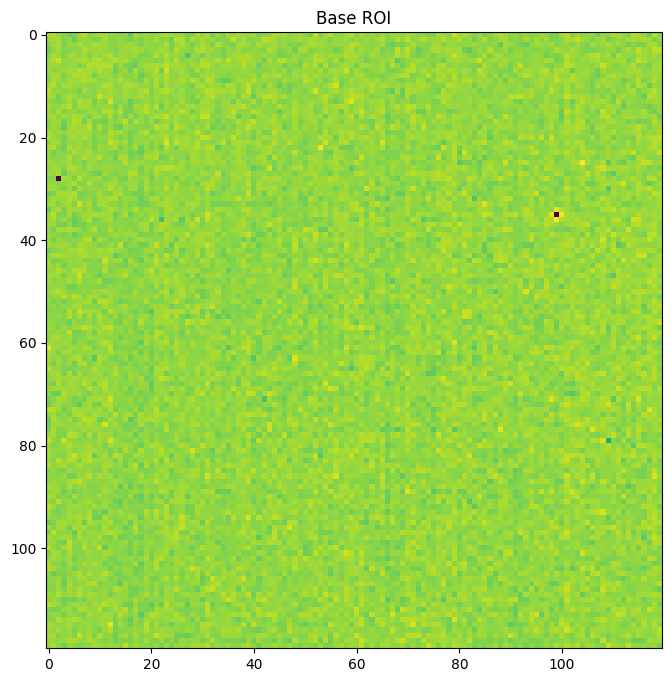

In [7]:
base_roi_rect: RoiRectangle = RoiRectangle(x1=320, y1=70, x2=440, y2=190)
base_roi_images: npt.NDArray = base_roi_rect.slice(images)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(base_roi_images.sum(0)))
ax.set_title("Base ROI")

base_roi_rect

RoiRectangle(x1=352, y1=98, x2=411, y2=159)
RoiRectangle(x1=32, y1=28, x2=91, y2=89)


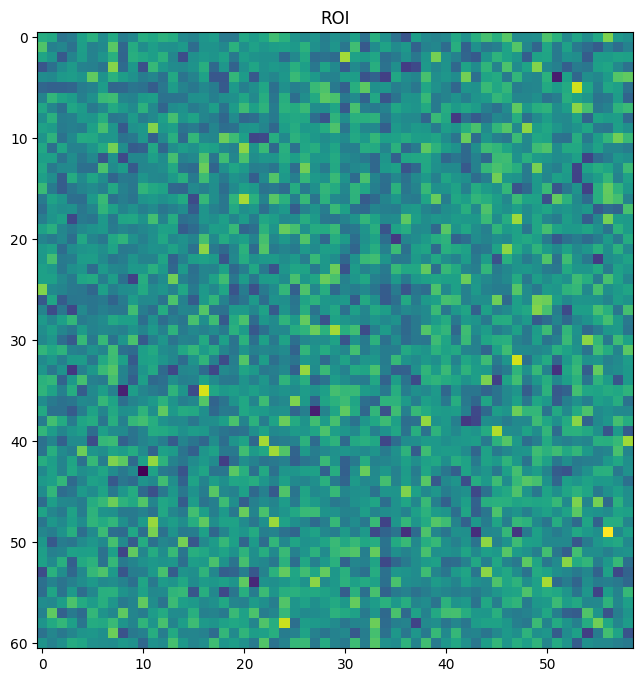

In [8]:
absolute_roi_rect: RoiRectangle = RoiRectangle(x1=352, y1=98, x2=411, y2=159)
roi_images: npt.NDArray = absolute_roi_rect.slice(images)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_images.sum(0)))
ax.set_title("ROI")

relative_roi_rect = absolute_roi_rect.move(-base_roi_rect.x1, -base_roi_rect.y1)
print(absolute_roi_rect)
print(relative_roi_rect)

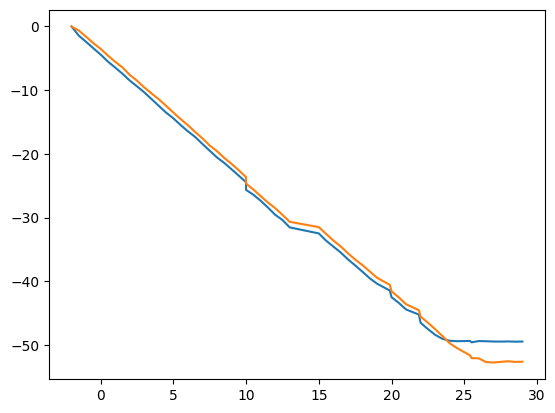

In [9]:
from scipy.ndimage import center_of_mass, gaussian_filter
from scipy.interpolate import UnivariateSpline


def track_dynamic_roi(
    frames, initial_roi: RoiRectangle, smoothing_factor=2
) -> tuple[npt.NDArray, npt.NDArray, list[RoiRectangle]]:
    centers = []
    roi = initial_roi
    rois = []
    for frame in frames:
        # Apply Gaussian filter to smooth noise
        smoothed_frame = gaussian_filter(frame, sigma=2)

        # Crop ROI dynamically
        roi_frame = roi.slice(smoothed_frame)

        # Calculate center of mass within ROI
        com = center_of_mass(roi_frame)
        global_com = (roi.y1 + com[0], roi.x1 + com[1])
        centers.append(global_com)

        # Update ROI dynamically
        roi = RoiRectangle(
            y1=max(0, int(global_com[0] - 10)),  # Adjust ROI size
            y2=min(frame.shape[0], int(global_com[0] + 10)),
            x1=max(0, int(global_com[1] - 10)),
            x2=min(frame.shape[1], int(global_com[1] + 10)),
        )
        rois.append(roi)
    # Smooth the trajectory
    centers = np.array(centers)
    smoothed_x = UnivariateSpline(
        range(len(centers)), centers[:, 0], s=smoothing_factor
    )
    smoothed_y = UnivariateSpline(
        range(len(centers)), centers[:, 1], s=smoothing_factor
    )

    return smoothed_x(range(len(centers))), smoothed_y(range(len(centers))), rois


plt.close()
xs, ys, rois = track_dynamic_roi(base_roi_images, relative_roi_rect, 0)
plt.plot(delays, xs - xs[0])
plt.plot(delays, ys - ys[0]);

In [10]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


def save_frames_with_roi(frames, rois, centers, output_folder):
    """
    이미지에 ROI 박스와 픽의 위치를 표시하고, 각 프레임을 특정 폴더에 저장합니다.

    Parameters:
        frames (list of np.ndarray): 입력 이미지 프레임 리스트.
        rois (list of RoiRectangle): 각 프레임에 대한 ROI 박스 리스트.
        centers (list of tuple): 각 프레임에 대한 픽의 위치 리스트.
        output_folder (str): 저장할 폴더 경로.
    """
    # 저장할 폴더가 없으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    pbar = tqdm(enumerate(zip(frames, rois, centers)), total=len(frames))
    for i, (frame, roi, center) in pbar:
        # 이미지 표시
        plt.figure(figsize=(10, 10))
        plt.imshow(frame)  # 그레이스케일 이미지인 경우

        # ROI 박스 그리기 (빨간색)
        roi_box = plt.Rectangle(
            (roi.x1, roi.y1),
            roi.x2 - roi.x1,
            roi.y2 - roi.y1,
            edgecolor="red",
            facecolor="none",
            linewidth=0.5,
        )
        plt.gca().add_patch(roi_box)

        # 픽의 위치 표시 (파란색 점)
        plt.scatter(center[1], center[0], color="black", s=0.5)

        # 축 제거 및 프레임 저장
        plt.axis("off")
        plt.savefig(
            f"{output_folder}/frame_{i:04d}.png", bbox_inches="tight", pad_inches=0
        )
        plt.close()

    print(f"모든 프레임이 {output_folder} 폴더에 저장되었습니다.")


# 예제 사용
# track_dynamic_roi 함수를 통해 ROI와 픽의 위치를 계산
xs, ys, rois = track_dynamic_roi(base_roi_images, relative_roi_rect)
centers = zip(xs, ys)
# 이미지와 ROI, 픽의 위치를 시각화하여 각 프레임을 저장
save_frames_with_roi(
    np.log1p(base_roi_images), rois, centers, output_folder="output_frames"
)

100%|██████████| 61/61 [00:03<00:00, 17.01it/s]

모든 프레임이 output_frames 폴더에 저장되었습니다.
